# Business Understanding

Proyek ini bertujuan untuk membangun model prediktif yang dapat memperkirakan harga penutupan saham harian PT Aneka Tambang Tbk (ANTM) menggunakan pendekatan machine learning berbasis time series. Model ini diharapkan mampu memberikan wawasan prediktif yang berguna bagi investor atau analis pasar dalam mengambil keputusan investasi. Dataset yang digunakan mencakup harga saham harian ANTM dari tahun 2021 hingga 2025, yang diperoleh dari situs Investing.com (https://id.investing.com/equities/aneka-tambang-historical-data). 

# Data Understanding

### Data Loading

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

Pada tahap ini, dilakukan proses eksplorasi awal terhadap data historis harga saham PT Aneka Tambang Tbk (ANTM) yang telah diunduh dari situs Investing.com. Dataset tersebut mencakup harga saham harian dari tanggal 21 Januari 2021 hingga 21 Mei 2025 dengan total 1.042 entri data dan 7 kolom fitur, yaitu:

- Tanggal: Tanggal pencatatan data.
- Terakhir: Harga penutupan saham pada hari tersebut.
- Pembukaan: Harga pembukaan saham.
- Tertinggi: Harga tertinggi yang dicapai pada hari tersebut.
- Terendah: Harga terendah pada hari tersebut.
- Vol.: Volume transaksi saham.
- Perubahan%: Persentase perubahan harga dari hari sebelumnya.

In [2]:
url = 'https://drive.google.com/uc?id=1rz3hHYITPxWD7ypSA_xAbfwI-Yj-acYF'
df = pd.read_csv(url)
df.head()


,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,21/05/2025,2.91,2.78,2.92,2.77,"329,77M","6,59%"
1,20/05/2025,2.73,2.72,2.74,2.66,"163,23M","0,37%"
2,19/05/2025,2.72,2.67,2.73,2.64,"210,29M","3,03%"
3,16/05/2025,2.64,2.66,2.67,2.60,"174,86M","3,53%"
4,15/05/2025,2.55,2.53,2.66,2.50,"332,82M","0,00%"


In [3]:
df.info()
print("Jumlah baris dan kolom:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tanggal     1042 non-null   object 
 1   Terakhir    1042 non-null   float64
 2   Pembukaan   1042 non-null   float64
 3   Tertinggi   1042 non-null   float64
 4   Terendah    1042 non-null   float64
 5   Vol.        1042 non-null   object 
 6   Perubahan%  1042 non-null   object 
dtypes: float64(4), object(3)
memory usage: 57.1+ KB
Jumlah baris dan kolom: (1042, 7)


Dari hasil df.info() diketahui bahwa sebagian besar kolom numerik sudah dalam format float64. Namun kolom Tanggal, Vol. dan Perubahan% masih berbentuk object, sehingga perlu dilakukan proses transformasi lebih lanjut agar bisa dianalisis secara kuantitatif.

### Transformasi Data

Data pada kolom Tanggal awalnya dalam bentuk object (string) dan perlu dikonversi ke format datetime agar Konversi dan pengurutan data secara kronologis agar sesuai dengan analisis time series.

In [4]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'], dayfirst=True)
df = df.sort_values('Tanggal').reset_index(drop=True)
df

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2021-01-21,3.09,3.29,3.34,3.03,"1,27B","-3,13%"
1,2021-01-22,2.88,3.09,3.09,2.88,"894,77M","-6,80%"
2,2021-01-25,2.87,2.76,2.96,2.68,"1,22B","-0,35%"
3,2021-01-26,2.67,2.90,2.93,2.67,"786,82M","-6,97%"
4,2021-01-27,2.55,2.62,2.74,2.49,"1,34B","-4,49%"
...,...,...,...,...,...,...,...
1037,2025-05-15,2.55,2.53,2.66,2.50,"332,82M","0,00%"
1038,2025-05-16,2.64,2.66,2.67,2.60,"174,86M","3,53%"
1039,2025-05-19,2.72,2.67,2.73,2.64,"210,29M","3,03%"
1040,2025-05-20,2.73,2.72,2.74,2.66,"163,23M","0,37%"


Kolom Vol. awalnya menggunakan notasi seperti 329,77M atau 894,77M, sehingga perlu dikonversi menjadi angka sehingga nilai volume kini berada dalam satuan numerik (float64) dengan satuan lot saham.

In [5]:
# Konversi Volume
def convert_volume(vol_str):
    if pd.isna(vol_str):
        return 0
    vol_str = str(vol_str)  # pastikan jadi string dulu
    vol_str = vol_str.replace('.', '')  
    vol_str = vol_str.replace(',', '.')  
    if vol_str.endswith('M'):
        return float(vol_str[:-1]) * 1_000_000
    elif vol_str.endswith('K'):
        return float(vol_str[:-1]) * 1_000
    elif vol_str.endswith('B'):
        return float(vol_str[:-1]) * 1_000_000_000
    else:
        try:
            return float(vol_str)
        except:
            return 0

df['Vol.'] = df['Vol.'].apply(convert_volume)
df.rename(columns={'Vol.': 'Volume'}, inplace=True)
df

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Volume,Perubahan%
0,2021-01-21,3.09,3.29,3.34,3.03,1.270000e+09,"-3,13%"
1,2021-01-22,2.88,3.09,3.09,2.88,8.947700e+08,"-6,80%"
2,2021-01-25,2.87,2.76,2.96,2.68,1.220000e+09,"-0,35%"
3,2021-01-26,2.67,2.90,2.93,2.67,7.868200e+08,"-6,97%"
4,2021-01-27,2.55,2.62,2.74,2.49,1.340000e+09,"-4,49%"
...,...,...,...,...,...,...,...
1037,2025-05-15,2.55,2.53,2.66,2.50,3.328200e+08,"0,00%"
1038,2025-05-16,2.64,2.66,2.67,2.60,1.748600e+08,"3,53%"
1039,2025-05-19,2.72,2.67,2.73,2.64,2.102900e+08,"3,03%"
1040,2025-05-20,2.73,2.72,2.74,2.66,1.632300e+08,"0,37%"


Kolom Perubahan% berisi string sehingga diperlukan untuk enghapus tanda persen dan mengganti koma dengan titik desimal dan konversi ke float sehingga siap digunakan sebagai fitur numerik.

In [6]:
# Hapus tanda % dan ganti koma dengan titik, lalu konversi ke float
df['Perubahan%'] = df['Perubahan%'].str.replace('%', '', regex=False).str.replace(',', '.', regex=False).astype(float)
df


,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Volume,Perubahan%
0,2021-01-21,3.09,3.29,3.34,3.03,1.270000e+09,-3.13
1,2021-01-22,2.88,3.09,3.09,2.88,8.947700e+08,-6.80
2,2021-01-25,2.87,2.76,2.96,2.68,1.220000e+09,-0.35
3,2021-01-26,2.67,2.90,2.93,2.67,7.868200e+08,-6.97
4,2021-01-27,2.55,2.62,2.74,2.49,1.340000e+09,-4.49
...,...,...,...,...,...,...,...
1037,2025-05-15,2.55,2.53,2.66,2.50,3.328200e+08,0.00
1038,2025-05-16,2.64,2.66,2.67,2.60,1.748600e+08,3.53
1039,2025-05-19,2.72,2.67,2.73,2.64,2.102900e+08,3.03
1040,2025-05-20,2.73,2.72,2.74,2.66,1.632300e+08,0.37


In [7]:
df.info()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Tanggal     1042 non-null   datetime64[ns]
 1   Terakhir    1042 non-null   float64       
 2   Pembukaan   1042 non-null   float64       
 3   Tertinggi   1042 non-null   float64       
 4   Terendah    1042 non-null   float64       
 5   Volume      1042 non-null   float64       
 6   Perubahan%  1042 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 57.1 KB


np.int64(0)

Dataset telah berhasil dibersihkan dan ditransformasikan menjadi bentuk yang siap diproses untuk eksplorasi lanjutan atau dimasukkan ke dalam model prediktif. Hal ini memastikan format waktu valid dan urut, data numerik siap distandardisasi dan informasi penting seperti volume dan perubahan harga dapat dianalisis secara akurat. Dataset juga tidak memiliki missing values dan duplikat data.



# Exploratory Data Analysis (EDA)

In [8]:
df.describe()

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Volume,Perubahan%
count,1042,1042.000000,1042.000000,1042.000000,1042.000000,1.042000e+03,1042.000000
mean,2023-03-12 16:48:49.750479872,1.967303,1.972538,2.004376,1.938052,1.154485e+08,0.028839
min,2021-01-21 00:00:00,1.210000,1.200000,1.225000,1.175000,1.129000e+07,-14.370000
25%,2022-02-09 06:00:00,1.625000,1.630000,1.650000,1.610000,4.081000e+07,-1.415000
50%,2023-02-28 12:00:00,1.970000,1.970000,1.990000,1.950000,6.863500e+07,-0.125000
75%,2024-04-04 18:00:00,2.290000,2.300000,2.340000,2.270000,1.258525e+08,1.280000
max,2025-05-21 00:00:00,3.090000,3.290000,3.340000,3.030000,2.190000e+09,17.120000
std,NaN,0.399821,0.401230,0.412064,0.388767,1.673159e+08,2.766404


### Visualisasi Tren Harga

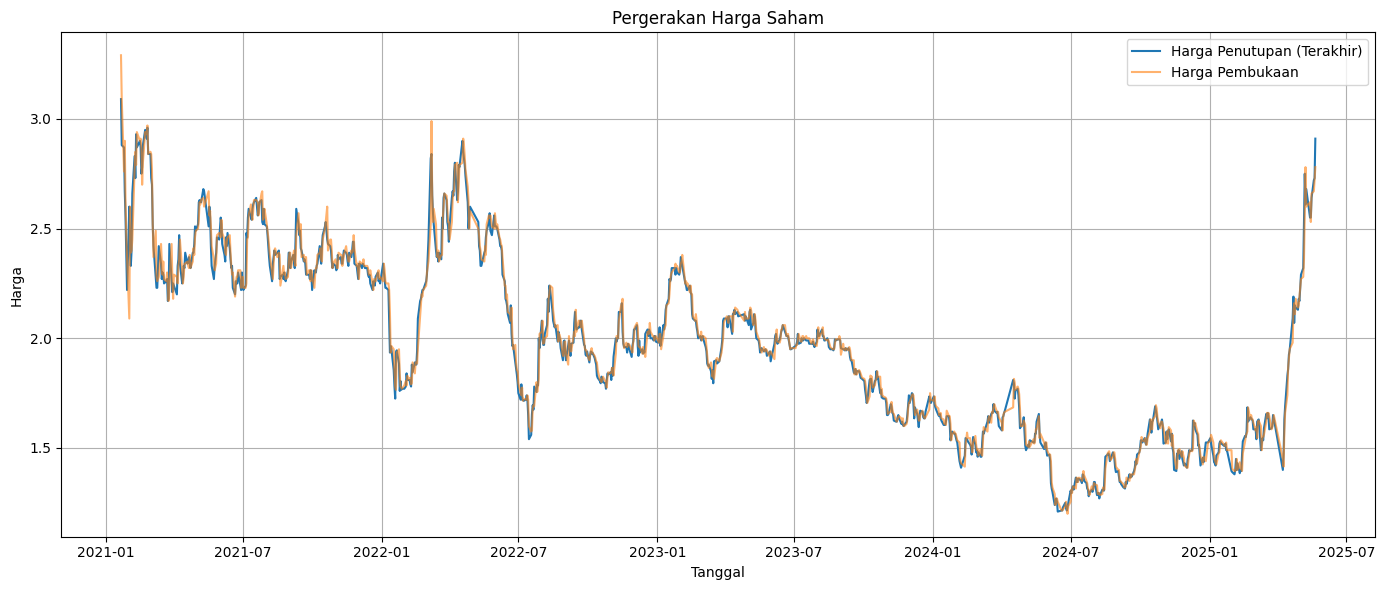

In [9]:
plt.figure(figsize=(14,6))
plt.plot(df['Tanggal'], df['Terakhir'], label='Harga Penutupan (Terakhir)')
plt.plot(df['Tanggal'], df['Pembukaan'], label='Harga Pembukaan', alpha=0.6)
plt.title('Pergerakan Harga Saham')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Grafik menunjukkan pergerakan harga pembukaan dan penutupan saham ANTM dari Januari 2021 hingga Mei 2025. Harga saham sempat naik tinggi di awal 2021, kemudian cenderung menurun dan stagnan hingga awal 2024. Mulai pertengahan 2024, harga saham menunjukkan tren naik yang tajam, menandakan adanya sentimen positif atau perbaikan kinerja perusahaan. Pergerakan harga pembukaan dan penutupan relatif berdekatan, menunjukkan stabilitas intraday.

### Visualisasi Volume Perdagangan

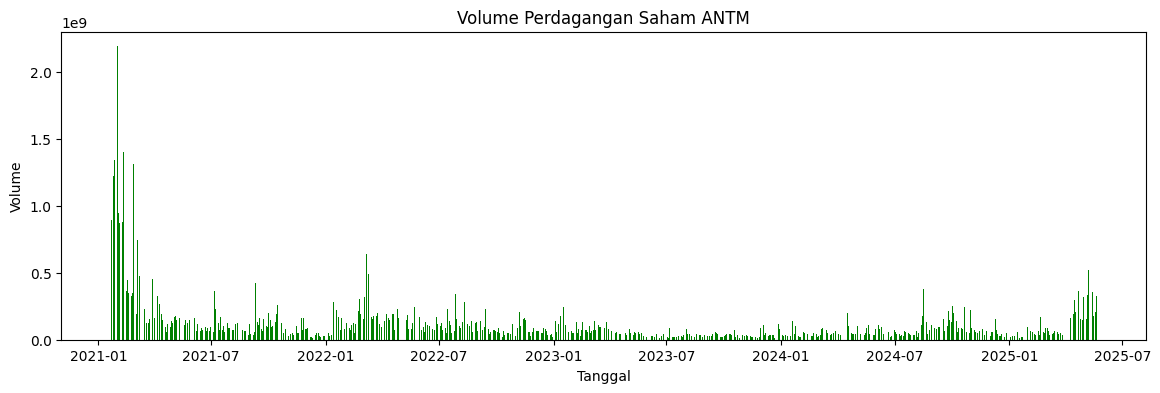

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
plt.bar(df['Tanggal'], df['Volume'], color='green')
plt.title('Volume Perdagangan Saham ANTM')
plt.xlabel('Tanggal')
plt.ylabel('Volume')
plt.show()

Visualisasi ini menunjukkan pergerakan volume perdagangan saham ANTM dari waktu ke waktu. Terlihat adanya lonjakan volume yang sangat signifikan pada awal 2021, yang kemungkinan dipicu oleh sentimen pasar atau aksi korporasi besar. Setelah lonjakan tersebut, volume mengalami penurunan dan cenderung stabil pada level yang lebih rendah, dengan beberapa lonjakan kecil yang sporadis di tahun-tahun berikutnya. Ini mencerminkan minat investor yang sempat memuncak lalu menurun, serta fluktuasi minat pasar terhadap saham ini.

### Distribusi Perubahan Persentase Harga

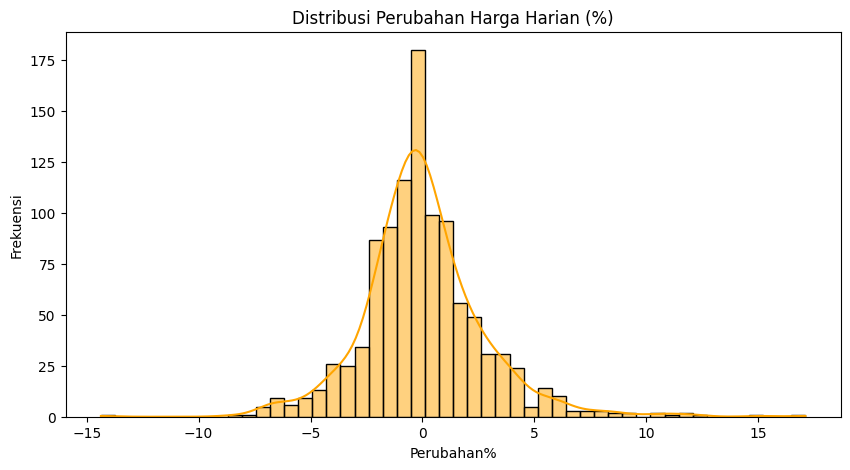

In [11]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df['Perubahan%'], bins=50, kde=True, color='orange')
plt.title('Distribusi Perubahan Harga Harian (%)')
plt.xlabel('Perubahan%')
plt.ylabel('Frekuensi')
plt.show()


Grafik histogram ini menggambarkan distribusi perubahan harga harian saham ANTM. Bentuk distribusinya menyerupai distribusi normal dengan puncak di sekitar 0%, menandakan bahwa sebagian besar perubahan harian berada di kisaran -5% hingga +5%. Tidak banyak outlier ekstrem, yang menunjukkan volatilitas harian yang relatif moderat. Distribusi yang cukup simetris juga menandakan tidak adanya bias besar terhadap tren kenaikan atau penurunan ekstrem dalam satu hari perdagangan.

### Korelasi Antar Kolom

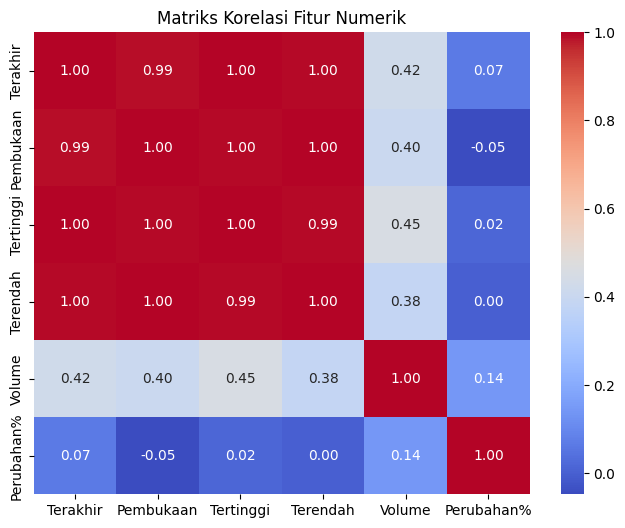

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriks Korelasi Fitur Numerik')
plt.show()

Heatmap ini menggambarkan korelasi antar fitur numerik seperti Open, High, Low, Close, Volume, dan Change %. Terdapat korelasi sangat tinggi (mendekati 1.0) antara harga pembukaan, tertinggi, terendah, dan penutupan, menunjukkan bahwa pergerakan harga harian sangat selaras. Namun, volume dan persentase perubahan harga menunjukkan korelasi yang lebih lemah terhadap variabel harga, menandakan bahwa aktivitas perdagangan tidak selalu linear terhadap perubahan harga.

### Musiman & Tren Bulanan

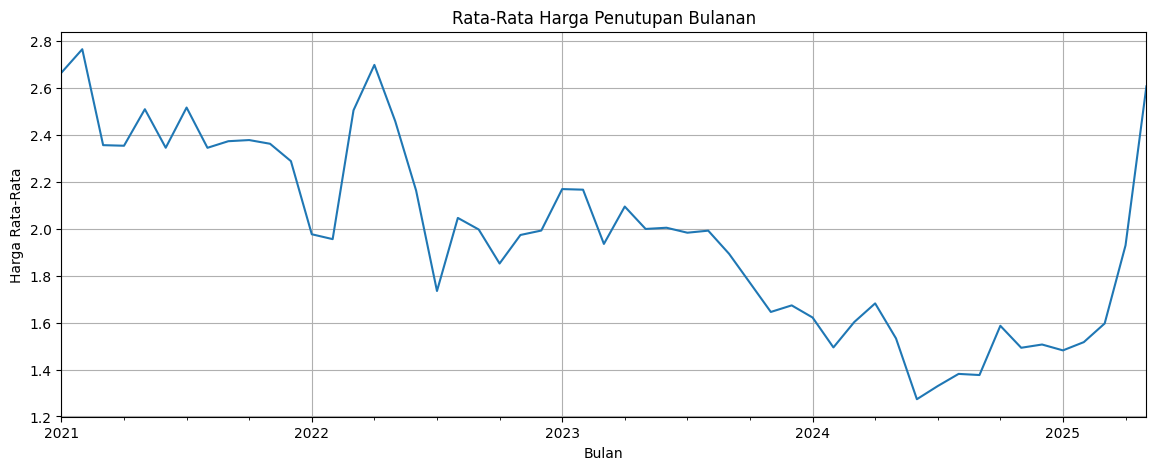

In [13]:
df['Bulan'] = df['Tanggal'].dt.to_period('M')
monthly_avg = df.groupby('Bulan')['Terakhir'].mean()

plt.figure(figsize=(14, 5))
monthly_avg.plot()
plt.title('Rata-Rata Harga Penutupan Bulanan')
plt.xlabel('Bulan')
plt.ylabel('Harga Rata-Rata')
plt.grid(True)
plt.show()


Line chart ini menunjukkan tren rata-rata harga penutupan per bulan. Terlihat bahwa harga penutupan bulanan mengalami penurunan dari akhir 2021 hingga awal 2024. Namun, tren ini berbalik arah setelahnya, dengan harga mulai naik secara konsisten hingga pertengahan 2025. Ini menunjukkan kemungkinan pemulihan kinerja perusahaan atau perbaikan sentimen pasar terhadap saham ANTM.

# Data Preparation

In [14]:
# Pastikan kolom penting
features = ['Pembukaan', 'Tertinggi', 'Terendah', 'Volume', 'Perubahan%', 'Terakhir']

Dengan mendefinisikan list features seperti ini, kita bisa mendefinisikan daftar nama kolom (fitur) yang penting atau relevan untuk digunakan dalam proses analisis dan modelling.

### Feature Engineering

In [15]:
# Buat lag fitur untuk harga Terakhir (1, 3, 5 hari sebelumnya)
df['Terakhir_lag1'] = df['Terakhir'].shift(1)
df['Terakhir_lag3'] = df['Terakhir'].shift(3)
df['Terakhir_lag5'] = df['Terakhir'].shift(5)
df

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Volume,Perubahan%,Bulan,Terakhir_lag1,Terakhir_lag3,Terakhir_lag5
0,2021-01-21,3.09,3.29,3.34,3.03,1.270000e+09,-3.13,2021-01,NaN,NaN,NaN
1,2021-01-22,2.88,3.09,3.09,2.88,8.947700e+08,-6.80,2021-01,3.09,NaN,NaN
2,2021-01-25,2.87,2.76,2.96,2.68,1.220000e+09,-0.35,2021-01,2.88,NaN,NaN
3,2021-01-26,2.67,2.90,2.93,2.67,7.868200e+08,-6.97,2021-01,2.87,3.09,NaN
4,2021-01-27,2.55,2.62,2.74,2.49,1.340000e+09,-4.49,2021-01,2.67,2.88,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1037,2025-05-15,2.55,2.53,2.66,2.50,3.328200e+08,0.00,2025-05,2.55,2.61,2.54
1038,2025-05-16,2.64,2.66,2.67,2.60,1.748600e+08,3.53,2025-05,2.55,2.68,2.75
1039,2025-05-19,2.72,2.67,2.73,2.64,2.102900e+08,3.03,2025-05,2.64,2.55,2.61
1040,2025-05-20,2.73,2.72,2.74,2.66,1.632300e+08,0.37,2025-05,2.72,2.55,2.68


Lag features adalah mengambil nilai harga Terakhir pada hari sebelumnya (lag 1), 3 hari sebelumnya (lag 3), dan 5 hari sebelumnya (lag 5). Tujuannya agar model bisa melihat pengaruh harga masa lalu terhadap harga saat ini (capturing temporal dependencies).

In [16]:
# Moving average untuk harga Terakhir (window 3 dan 5)
df['Terakhir_MA3'] = df['Terakhir'].rolling(window=3).mean()
df['Terakhir_MA5'] = df['Terakhir'].rolling(window=5).mean()
df

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Volume,Perubahan%,Bulan,Terakhir_lag1,Terakhir_lag3,Terakhir_lag5,Terakhir_MA3,Terakhir_MA5
0,2021-01-21,3.09,3.29,3.34,3.03,1.270000e+09,-3.13,2021-01,NaN,NaN,NaN,NaN,NaN
1,2021-01-22,2.88,3.09,3.09,2.88,8.947700e+08,-6.80,2021-01,3.09,NaN,NaN,NaN,NaN
2,2021-01-25,2.87,2.76,2.96,2.68,1.220000e+09,-0.35,2021-01,2.88,NaN,NaN,2.946667,NaN
3,2021-01-26,2.67,2.90,2.93,2.67,7.868200e+08,-6.97,2021-01,2.87,3.09,NaN,2.806667,NaN
4,2021-01-27,2.55,2.62,2.74,2.49,1.340000e+09,-4.49,2021-01,2.67,2.88,NaN,2.696667,2.812
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,2025-05-15,2.55,2.53,2.66,2.50,3.328200e+08,0.00,2025-05,2.55,2.61,2.54,2.593333,2.628
1038,2025-05-16,2.64,2.66,2.67,2.60,1.748600e+08,3.53,2025-05,2.55,2.68,2.75,2.580000,2.606
1039,2025-05-19,2.72,2.67,2.73,2.64,2.102900e+08,3.03,2025-05,2.64,2.55,2.61,2.636667,2.628
1040,2025-05-20,2.73,2.72,2.74,2.66,1.632300e+08,0.37,2025-05,2.72,2.55,2.68,2.696667,2.638


Moving average features ini menghitung rata-rata harga Terakhir selama 3 hari terakhir dan 5 hari terakhir. Moving average ini membantu model menangkap tren jangka pendek (3 hari) dan menengah (5 hari) yang mungkin relevan untuk prediksi harga atau perilaku pasar.

In [17]:
# Drop baris dengan nilai NaN akibat shift dan rolling
df.dropna(inplace=True)
df

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Volume,Perubahan%,Bulan,Terakhir_lag1,Terakhir_lag3,Terakhir_lag5,Terakhir_MA3,Terakhir_MA5
5,2021-01-28,2.38,2.47,2.57,2.38,7.318500e+08,-6.67,2021-01,2.55,2.87,3.09,2.533333,2.670
6,2021-01-29,2.22,2.37,2.44,2.22,4.503200e+08,-6.72,2021-01,2.38,2.67,2.88,2.383333,2.538
7,2021-02-01,2.60,2.09,2.64,2.07,2.190000e+09,17.12,2021-02,2.22,2.55,2.87,2.400000,2.484
8,2021-02-02,2.42,2.60,2.63,2.42,9.424300e+08,-6.92,2021-02,2.60,2.38,2.67,2.413333,2.434
9,2021-02-03,2.33,2.39,2.52,2.29,9.480300e+08,-3.72,2021-02,2.42,2.22,2.55,2.450000,2.390
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,2025-05-15,2.55,2.53,2.66,2.50,3.328200e+08,0.00,2025-05,2.55,2.61,2.54,2.593333,2.628
1038,2025-05-16,2.64,2.66,2.67,2.60,1.748600e+08,3.53,2025-05,2.55,2.68,2.75,2.580000,2.606
1039,2025-05-19,2.72,2.67,2.73,2.64,2.102900e+08,3.03,2025-05,2.64,2.55,2.61,2.636667,2.628
1040,2025-05-20,2.73,2.72,2.74,2.66,1.632300e+08,0.37,2025-05,2.72,2.55,2.68,2.696667,2.638


Karena operasi shift() dan rolling() akan menghasilkan nilai kosong (NaN) pada baris awal (karena data sebelumnya tidak ada), baris ini dihapus agar data siap dipakai untuk modeling tanpa error. Dengan menambah fitur lag dan moving average, kita bisa memperkaya data dengan informasi temporal yang penting untuk analisis deret waktu (time series) atau prediksi harga saham, sehingga model bisa lebih akurat memahami pola dan tren harga dari waktu ke waktu.

### Feature Selection

In [18]:
# Siapkan data input dan target
input_features = ['Pembukaan', 'Tertinggi', 'Terendah', 'Volume', 'Perubahan%', 
                  'Terakhir_lag1', 'Terakhir_lag3', 'Terakhir_lag5', 'Terakhir_MA3', 'Terakhir_MA5']

Tujuan Feature Selection adalah memfokuskan proses modeling hanya pada fitur-fitur yang dianggap relevan berdasarkan domain knowledge dan hasil EDA, mengurangi noise dan kompleksitas model.

### Data Splitting

In [19]:
X = df[input_features].values
y = df['Terakhir'].values  # Target = harga penutupan hari ini

# Split 80:20 tanpa shuffle (karena time-series)
split_idx = int(len(df) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


Memisahkan dataset menjadi dua bagian: data latih (train) dan data uji (test) dengan rasio 80:20. Data tidak diacak (no shuffling) karena ini merupakan data deret waktu (time series), sehingga urutan kronologis tetap terjaga.

### Scaling / Normalization

In [20]:
from sklearn.preprocessing import MinMaxScaler

# Inisialisasi scaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit di data training, transform semua
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))


Melakukan normalisasi data agar seluruh nilai fitur (X) dan target (y) berada dalam rentang 0 hingga 1. Scaling dilakukan dengan MinMaxScaler, dan fitting hanya pada data training untuk menghindari data leakage. Tujuannya adalah untuk membantu model konvergen lebih cepat dan stabil selama proses pelatihan, terutama pada model berbasis neural network dan juga menjaga proporsi dan skala fitur agar tidak ada fitur yang mendominasi karena skala yang besar.

### Reshape untuk LSTM

In [21]:
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


Mengubah bentuk data input menjadi 3 dimensi agar kompatibel dengan input model LSTM, yaitu (samples, timesteps, features). Karena fitur sudah mencerminkan informasi historis (melalui lag dan moving average), maka timesteps diset ke 1.Tujuannya adalah menyesuaikan bentuk data input dengan kebutuhan arsitektur LSTM yang membutuhkan input dalam bentuk sekuens 3D dan memastikan model bisa memahami pola waktu dari data harian.

# Modelling

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras_tuner import HyperParameters
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

Pada Modeling kali ini, saya  hanya akan menggunkaan 1 algoritma yaitu LSTM. Oleh karena itu saya akan melakukan improvement pada baseline model dengan hyperparameter tuning dengan Keras Tuner.

 Keras Tuner digunakan untuk secara otomatis mencari kombinasi hyperparameter terbaik pada model LSTM, seperti jumlah neuron, dropout rate, dan learning rate. Dengan cara ini, proses tuning jadi lebih efisien dan sistematis dibandingkan coba-coba manual, sehingga model yang dihasilkan lebih akurat dan tidak mudah overfitting. Selain itu, Keras Tuner mudah diintegrasikan dengan Keras/TensorFlow dan mempercepat eksperimen dengan fitur seperti EarlyStopping. Singkatnya, Keras Tuner membantu mendapatkan model LSTM yang optimal dengan lebih cepat dan handal.

### Buat Fungsi Model Builder untuk Keras Tuner

Fungsi build_model bertujuan membangun model LSTM untuk regresi dengan hyperparameter yang dapat di-tune secara otomatis menggunakan Keras Tuner. Fungsi ini menerima objek hp (hyperparameter tuner) dan mengembalikan model Keras yang sudah dikompilasi. 

In [23]:
def build_model(hp):
    model = keras.Sequential()
    
    # Layer LSTM dengan units yang ditentukan oleh tuner
    model.add(keras.layers.LSTM(
        units=hp.Choice('units', values=[32, 64, 128]),
        activation='tanh',
        input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])
    ))
    
    # Dropout layer untuk regularisasi
    model.add(keras.layers.Dropout(
        rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])
    ))

    # Output layer regresi
    model.add(keras.layers.Dense(1))
    
    # Compile model dengan learning rate yang ditentukan tuner
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='mse',
        metrics=['mae']
    )
    
    return model


Tahapan dan Parameter yang Digunakan

1. Layer LSTM
    - units: Jumlah neuron pada layer LSTM, dipilih secara otomatis dari opsi [32, 64, 128].
    - activation: Fungsi aktivasi tanh digunakan karena umum dan efektif pada RNN/LSTM.
    - input_shape: Bentuk input yang disesuaikan dengan data latih (biasanya (timesteps, fitur)).
2. Dropout Layer
     - rate: Tingkat dropout untuk regularisasi, dipilih dari [0.1, 0.2, 0.3]. Dropout membantu mengurangi overfitting dengan mengacak neuron yang aktif selama training.
3. Output Layer (Dense)
    - 1 neuron tanpa aktivasi (linear) untuk menghasilkan prediksi regresi (harga saham).
4. Kompilasi Model
    - optimizer: Adam optimizer dengan learning rate yang juga di-tune otomatis, pilihan dari [0.01, 0.001, 0.0001].
    - loss: Mean Squared Error (mse) digunakan karena masalah ini adalah regresi.
    - metrics: Mean Absolute Error (mae) sebagai metrik evaluasi tambahan.

### Konfigurasi dan Jalankan Tuner

Proses hyperparameter tuning menggunakan Keras Tuner dengan metode RandomSearch dilakukan untuk mencari kombinasi parameter terbaik pada model LSTM, seperti jumlah unit neuron, dropout rate, dan learning rate. Fungsi model dibuat fleksibel agar tuner bisa mencoba variasi parameter tersebut. RandomSearch mengeksplorasi beberapa kombinasi secara acak dan efisien, lalu memilih yang memberikan nilai validasi loss terbaik. Proses training menggunakan EarlyStopping untuk mencegah overfitting dengan menghentikan pelatihan saat performa tidak membaik. Dengan cara ini, model LSTM dapat diimprove secara otomatis tanpa trial manual, sehingga mendapatkan model yang optimal dengan waktu dan sumber daya yang lebih efisien.

In [24]:
# Buat objek tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Jumlah kombinasi hyperparameter yang akan dicoba
    executions_per_trial=1,
    directory='keras_tuner_logs',
    project_name='lstm_natam'
)

# Jalankan pencarian hyperparameter terbaik
tuner.search(
    X_train_lstm, y_train_scaled,
    validation_data=(X_test_lstm, y_test_scaled),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

Reloading Tuner from keras_tuner_logs\lstm_natam\tuner0.json


Tahapan dan Parameter yang Digunakan
1. Inisialisasi Objek Tuner (RandomSearch)
    - build_model: Fungsi yang membangun model dengan hyperparameter yang dapat dipilih oleh tuner.
    - objective='val_loss': Tuner mengevaluasi model berdasarkan nilai loss pada data validasi, yaitu MSE terkecil.
    - max_trials=10: Mencoba maksimal 10 kombinasi hyperparameter berbeda.
    - executions_per_trial=1: Setiap kombinasi hyperparameter dieksekusi sekali saja (tanpa pengulangan).
    - directory dan project_name: Tempat penyimpanan hasil pencarian.
2. Proses Pencarian (tuner.search):
    - Melatih model dengan data training (X_train_lstm, y_train_scaled) dan validasi (X_test_lstm, y_test_scaled).
    - epochs=50 dan batch_size=32: Pengaturan training standar.
    - EarlyStopping: Menghentikan training jika tidak ada perbaikan val_loss selama 5 epoch berturut-turut dan mengembalikan bobot terbaik.
    - verbose=1: Menampilkan proses pencarian di output.

Saya mengambil model terbaik dan konfigurasi hyperparameter terbaik yang ditemukan oleh proses tuning menggunakan Keras Tuner. Hasil ini digunakan untuk melanjutkan tahap evaluasi dan deployment model dengan performa optimal.

In [25]:
# Ambil model terbaik
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]

# Tampilkan hasil tuning terbaik
print("Best Hyperparameters:")
print(f"Units        : {best_hp.get('units')}")
print(f"Dropout Rate : {best_hp.get('dropout')}")
print(f"Learning Rate: {best_hp.get('learning_rate')}")

c:\Users\T480\Documents\PREDIKTIF ANALYSIS\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best Hyperparameters:
Units        : 64
Dropout Rate : 0.2
Learning Rate: 0.01


c:\Users\T480\Documents\PREDIKTIF ANALYSIS\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Penjelasan Hasil:
- Units = 64: Model LSTM dengan 64 neuron pada layer LSTM memberikan performa terbaik.
- Dropout Rate = 0.2: Dropout rate 0.2 digunakan untuk mengurangi overfitting tanpa mengurangi kapasitas model terlalu banyak.
- Learning Rate = 0.01: Learning rate ini memastikan optimizer Adam melakukan update parameter dengan langkah yang optimal, mempercepat konvergensi tanpa melompati minimum loss.

### Ambil Model Terbaik dan Train Ulang

Saya mengambil model terbaik hasil tuning dan melatih ulang model tersebut dengan data training dan validasi untuk memaksimalkan performa model sebelum evaluasi dan deployment.

In [26]:
# Ambil model terbaik dari tuning
best_model = tuner.get_best_models(num_models=1)[0]

# Compile ulang model jika perlu
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)

# Training ulang (opsional, biasanya model terbaik sudah terlatih)
history = best_model.fit(
    X_train_lstm, y_train_scaled,
    validation_data=(X_test_lstm, y_test_scaled),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0026 - mae: 0.0393 - val_loss: 8.9814e-05 - val_mae: 0.0081
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.7551e-04 - mae: 0.0215 - val_loss: 7.1803e-05 - val_mae: 0.0059
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.4181e-04 - mae: 0.0211 - val_loss: 1.2720e-04 - val_mae: 0.0073
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.1341e-04 - mae: 0.0211 - val_loss: 3.3107e-04 - val_mae: 0.0166
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011 - mae: 0.0238 - val_loss: 1.4693e-04 - val_mae: 0.0095
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2702e-04 - mae: 0.0179 - val_loss: 1.1932e-04 - val_mae: 0.0080
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.5024e-04 - mae: 0.0195 - val_loss: 1.2842e-04 - val_mae: 0.0091


# Evaluation

### Prediksi dan inverse transform

In [27]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prediksi
y_pred_scaled = best_model.predict(X_test_lstm)

# Kembalikan ke skala asli
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

# Evaluasi
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
r2 = r2_score(y_test_actual, y_pred)

print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
MAE  : 0.0103
RMSE : 0.0148
R²   : 0.9977


Pada evaluasi model prediksi harga saham ini, digunakan tiga metrik utama:
1. MAE (Mean Absolute Error): Mengukur rata-rata besarnya selisih absolut antara nilai prediksi dengan nilai sebenarnya. Nilai MAE sebesar 0.0103 menunjukkan rata-rata kesalahan prediksi sangat kecil, sehingga model cukup akurat dalam memperkirakan harga penutupan saham.

2. RMSE (Root Mean Squared Error): Mengukur akar dari rata-rata kuadrat selisih prediksi dan nilai sebenarnya. RMSE sebesar 0.0148 menunjukkan kesalahan prediksi yang cukup kecil dan penalti untuk kesalahan besar lebih tinggi, menandakan model memiliki prediksi yang konsisten dan stabil.

3. R² (Koefisien Determinasi): Mengukur seberapa baik variansi data aktual dijelaskan oleh model. Nilai R² sebesar 0.9977 mendekati 1, yang berarti model sangat baik dalam menjelaskan variabilitas harga saham dan prediksi sangat mendekati nilai sebenarnya.

Kesimpulan: Berdasarkan ketiga metrik ini, model LSTM yang dibangun memiliki performa sangat baik untuk memprediksi harga penutupan saham PT ANTAM, dengan kesalahan prediksi yang sangat kecil dan akurasi yang tinggi.

Ketiga metrik ini sesuai untuk masalah regresi pada data time series harga saham karena mereka mengukur akurasi prediksi numerik dan kemampuan model menjelaskan variasi data asli.

### Visualisasi Prediksi vs Aktual

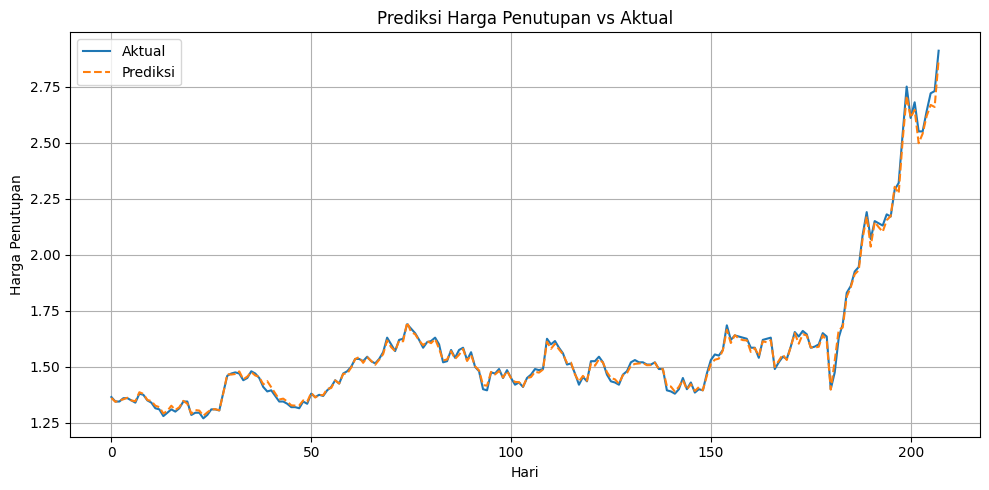

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test_actual, label='Aktual')
plt.plot(y_pred, label='Prediksi', linestyle='--')
plt.title('Prediksi Harga Penutupan vs Aktual')
plt.xlabel('Hari')
plt.ylabel('Harga Penutupan')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Berdasarkan visualisasi grafik “Prediksi Harga Penutupan vs Aktual”, dapat disimpulkan bahwa model prediktif yang digunakan memiliki performa yang sangat baik secara visual. Hal ini terlihat dari garis prediksi (berwarna oranye putus-putus) yang sangat mendekati garis aktual (berwarna biru), menunjukkan bahwa model mampu menangkap pola pergerakan harga secara akurat. Model juga berhasil mengikuti tren utama, termasuk lonjakan harga yang tajam di sekitar hari ke-180 hingga 200, yang menunjukkan kemampuan model dalam mendeteksi perubahan tren harga. Selain itu, tidak tampak adanya deviasi besar antara prediksi dan nilai aktual sepanjang periode waktu yang diamati, sehingga kesalahan prediksi (error) dapat dikatakan relatif rendah dan konsisten.

Adapun sumbu horizontal (sumbu X) yang ditandai dengan angka dari 0 hingga lebih dari 200 menunjukkan urutan hari dalam data uji (bukan tanggal sebenarnya), dengan asumsi bahwa satu unit merepresentasikan satu hari perdagangan. Misalnya, angka 0 menunjukkan hari pertama dalam data uji, angka 100 adalah hari ke-100, dan seterusnya. Oleh karena itu, grafik ini menggambarkan kinerja model prediksi selama lebih dari 200 hari berturut-turut, di mana prediksi model terlihat konsisten mengikuti pergerakan harga aktual sepanjang periode tersebut. Dengan demikian, model ini layak digunakan untuk keperluan peramalan harga dalam jangka pendek hingga menengah, selama tren harga tidak mengalami perubahan yang sangat ekstrem atau tiba-tiba.